In [1]:
import os

root_dir = "/kaggle/input/dcsass-dataset/DCSASS Dataset"

print("Dataset contents:", os.listdir(root_dir))

Dataset contents: ['RoadAccidents', 'Assault', 'Vandalism', 'Arrest', 'Labels', 'Shooting', 'Arson', 'Explosion', 'Shoplifting', 'Robbery', 'Stealing', 'Burglary', 'Abuse', 'Fighting']


## Libraries

In [2]:
!pip install fiftyone ultralytics --quiet
!pip install deep-sort-realtime

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 932.6/932.6 kB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.7/99.7 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.4/112.4 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 943.0/943.0 kB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 2.6 MB/s eta 0:00:0

In [3]:
import pandas as pd
import numpy as np
import os
import cv2
import torch
import matplotlib.pyplot as plt
import random
import math
import tensorflow as tf
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
# Set seed
seed_constant = 42
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

## Load Dataset (Shoplifting folder)

In [5]:
LABEL_DIR = os.path.join(root_dir, "Labels/Shoplifting.csv")
df = pd.read_csv(LABEL_DIR, header=None)
df.head()

,0,1,2
0,Shoplifting001_x264_0,Shoplifting,0
1,Shoplifting001_x264_1,Shoplifting,0
2,Shoplifting001_x264_2,Shoplifting,0
3,Shoplifting001_x264_3,Shoplifting,0
4,Shoplifting001_x264_4,Shoplifting,0


In [6]:
df = df.drop(columns=[1])
df = df.rename(columns={0: 'name'})
df = df.rename(columns={2: 'label'})

display(df.head())
df.shape

,name,label
0,Shoplifting001_x264_0,0
1,Shoplifting001_x264_1,0
2,Shoplifting001_x264_2,0
3,Shoplifting001_x264_3,0
4,Shoplifting001_x264_4,0


(896, 2)

In [7]:
# normal (0) & abnormal (1)
df['label'].value_counts()

label
0    741
1    155
Name: count, dtype: int64

## Set constant parameters

In [8]:
DATA_DIR = os.path.join(root_dir, "Shoplifting")
SEQUENCE_LENGTH = 20 # frames number of each video (step is 4 frames)
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64

yolo_model = YOLO("yolov8n.pt")

100%|██████████| 6.25M/6.25M [00:00<00:00, 120MB/s]


## 3. Function to extract, resize and normalize Frames

In [9]:
def extract_frames(video_path):
    """
    Args:
    - video_path: the path of video need to be extracted
    Returns:
    - frames_list: resized and normalized frames of the input video. Each person will stored in a list frames
    """
    global IMAGE_HEIGHT, IMAGE_WIDTH, SEQUENCE_LENGTH, yolo_model

    person_tracks = {}

    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Tracking
    tracker = DeepSort()

    while True:
        success, frame = video_reader.read()
        if not success:
            break

        results = yolo_model(frame, verbose=False)
        detections = []

        for result in results:
            boxes = result.boxes
            for box in boxes:
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                conf = round(box.conf[0].item(), 2)
                cls = int(box.cls[0])

                if cls == 0 and conf > 0.5:  # Detecting 'person'
                    current_arr = ([x1, y1, x2-x1, y2-y1], conf, cls)
                    detections.append(current_arr)

        resultsTracker = tracker.update_tracks(detections, frame=frame)
        for result in resultsTracker:
            id = result.track_id
            x1, y1, x2, y2 = map(int, result.to_ltrb())
            w, h = x2-x1, y2-y1

            person_crop = frame[y1:y2, x1:x2]
            if person_crop.size > 0:
                resized_frame = cv2.resize(person_crop, (IMAGE_WIDTH, IMAGE_HEIGHT))
                normalized_frame = resized_frame / 255.0  # Normalize

                if id not in person_tracks:
                    person_tracks[id] = []

                person_tracks[id].append(normalized_frame)

    video_reader.release()

    # Ensure exactly SEQUENCE_LENGTH frames per person
    keys_to_remove = []  # Store keys for removal
    for key in list(person_tracks.keys()):
        frames = person_tracks[key]
        num_frames = len(frames)

        if num_frames >= SEQUENCE_LENGTH:
            # Select SEQUENCE_LENGTH frames without reordering
            step = num_frames / SEQUENCE_LENGTH
            selected_indices = [int(i * step) for i in range(SEQUENCE_LENGTH)]
            person_tracks[key] = [frames[i] for i in selected_indices]
            # print(f"Person {key}: {len(person_tracks[key])} frames")
        else:
            keys_to_remove.append(key)

    for key in keys_to_remove:
        del person_tracks[key]

    # if len(list(person_tracks.keys())) == 0: return list(person_tracks.values())

    # # Display to check
    # index = list(person_tracks.keys())[0]
    # person_crops = person_tracks[index] # index is corresponded to a person
    # num_images = len(person_crops) # 4 imgs
    # fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    # if num_images == 1:
    #     axes = [axes]

    # for i, (ax, crop) in enumerate(zip(axes, person_crops[:num_images])):
    #     ax.imshow(crop)  # BGR channel
    #     ax.axis('off')

    # plt.show()

    return list(person_tracks.values())  # Convert to list of tracks

# frames_list = extract_frames(os.path.join(root_dir, "Shoplifting/Shoplifting006_x264.mp4/Shoplifting006_x264_0.mp4"))

## Function to create dataset

In [10]:
def create_dataset(DATA_DIR):
    """
    Returns:
    - features: 2D list, includes extracted frames in each video
    - labels: 1D list, includes corresponding label of each video
    """
    global df, SEQUENCE_LENGTH

    features = []
    labels = []

    for _, row in df.iterrows():
        video_name = row["name"]
        label = row["label"]
        video_folder = video_name.rsplit("_", 1)[0] + ".mp4"
        video_path = os.path.join(DATA_DIR, video_folder, video_name + ".mp4")

        extracted_frames = extract_frames(video_path)
        for frame in extracted_frames:
            # print(len(frame))
            if len(frame) == SEQUENCE_LENGTH:
                features.append(frame)
                labels.append(label)

    features = np.asarray(features)
    labels = np.array(labels)

    return features, labels

In [11]:
features, labels = create_dataset(DATA_DIR)
one_hot_labels = to_categorical(labels)

features.shape, one_hot_labels.shape

((1509, 20, 64, 64, 3), (1509, 2))

## Split dataset

In [12]:
# Split into 80% for training and 20% for testing
features_train, features_test, labels_train, labels_test = train_test_split(
    features, one_hot_labels, test_size=0.2, shuffle=True, random_state=seed_constant
)

## Create Model

In [13]:
input_shape = features_train[0].shape # (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)

def create_LRCN_model(label_nums=2):
    global input_shape

    model = Sequential()

    model.add(Input(shape=input_shape))

    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01))))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.3)))
    model.add(TimeDistributed(BatchNormalization()))

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01))))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.3)))
    model.add(TimeDistributed(BatchNormalization()))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01))))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.3)))
    model.add(TimeDistributed(BatchNormalization()))

    # Flatten and LSTM layers
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(64, return_sequences=False, kernel_regularizer=l2(0.01)))

    # Fully Connected Output Layer
    model.add(Dense(label_nums, activation='softmax'))

    model.summary()

    return model

In [14]:
model = create_LRCN_model()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 20, 64, 64, 16)      │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 20, 16, 16, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 20, 16, 16, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 20, 16, 16, 16)      │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 20, 16, 16, 32)      │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 20, 4, 4, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_6 (TimeDistributed) │ (None, 20, 4, 4, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_7 (TimeDistributed) │ (None, 20, 4, 4, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_8 (TimeDistributed) │ (None, 20, 4, 4, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_9 (TimeDistributed) │ (None, 20, 2, 2, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_10                  │ (None, 20, 2, 2, 64)        │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_11                  │ (None, 20, 2, 2, 64)        │             256 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_12                  │ (None, 20, 256)             │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 106,338 (415.38 KB)

 Trainable params: 106,114 (414.51 KB)

 Non-trainable params: 224 (896.00 B)

In [15]:
# Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor="val_loss", patience=5, mode="min", restore_best_weights=True)

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])

# Train
model_training_history = model.fit(x=features_train, y=labels_train, 
                                   epochs=50, batch_size=4,
                                   shuffle=True, validation_split=0.2,
                                   callbacks = [early_stopping_callback])

Epoch 1/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 41s 72ms/step - accuracy: 0.8505 - loss: 2.6284 - val_accuracy: 0.8306 - val_loss: 1.2543
Epoch 2/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.8714 - loss: 1.0504 - val_accuracy: 0.8388 - val_loss: 0.8523
Epoch 3/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.8706 - loss: 0.7399 - val_accuracy: 0.8306 - val_loss: 0.7301
Epoch 4/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.8743 - loss: 0.6113 - val_accuracy: 0.8306 - val_loss: 0.6521
Epoch 5/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.8734 - loss: 0.5399 - val_accuracy: 0.8306 - val_loss: 0.6069
Epoch 6/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.8761 - loss: 0.4998 - val_accuracy: 0.8306 - val_loss: 0.5731
Epoch 7/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.8711 - loss: 0.4869 - val_accuracy: 0.8347 - val_loss: 0.5666
Epoch 8/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.8658 - loss: 0.4789 - 

In [16]:
# Evaluate
model_evaluation = model.evaluate(features_test, labels_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8496 - loss: 0.4983


In [17]:
# Save model
model_file_name = "LRCN_model.h5"
model.save(model_file_name)

## Plot Loss & Accuracy Curves

In [18]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    # 'accuracy', 'loss', 'val_accuracy', 'val_loss'
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    plt.title(str(plot_name))
    plt.legend()

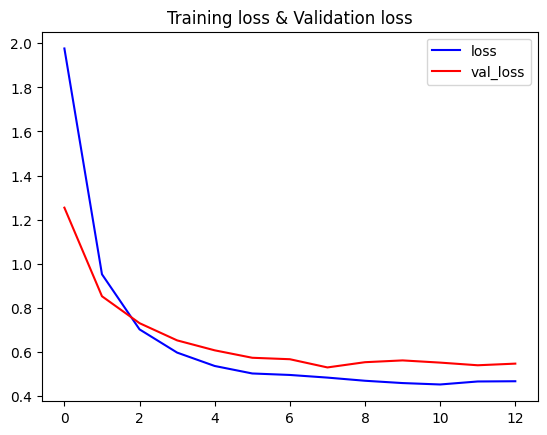

In [19]:
plot_metric(model_training_history, 'loss', 'val_loss', 'Training loss & Validation loss')

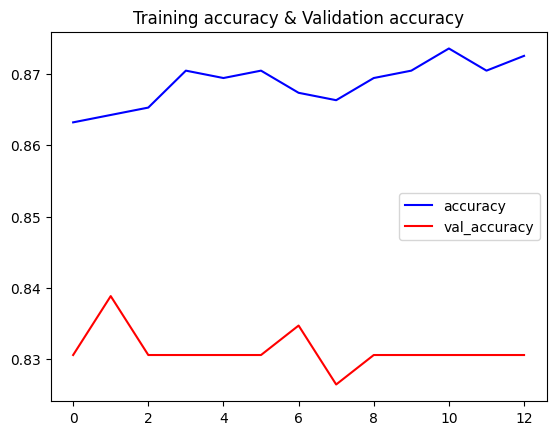

In [20]:
plot_metric(model_training_history, 'accuracy', 'val_accuracy', 'Training accuracy & Validation accuracy')

### Reference:
https://bleedaiacademy.com/human-activity-recognition-using-tensorflow-cnn-lstm/